The basic idea is to find out which categories of genomic regions (exons, promoters, enhancers, etc) contribute the most to the Nea. ancestry observed in present day Europeans. For example: have coding regions or enhancers been the main drivers of selection against Nea. introgression?

Links:

* info about different coordinate types: https://groups.google.com/forum/#!msg/biomart-users/OtQbAx3y9CA/wrF19ID1AgAJ
* https://www.biostars.org/p/2005/
* http://www.bioconductor.org/packages/release/bioc/vignettes/biomaRt/inst/doc/biomaRt.html#attribute-pages
* http://www.ensembl.org/info/data/biomart/biomart_r_package.html
* http://www.ensembl.info/blog/2015/06/01/biomart-or-how-to-access-the-ensembl-data-from-r/
* for checking with manually downloaded data: http://www.ensembl.org/info/data/biomart/how_to_use_biomart.html
* biotypes FAQ: http://www.ensembl.org/Help/Glossary

Following [this](http://www.ensembl.org/info/data/biomart/biomart_r_package.html) tutorial, I want to extract coordinates of exonic and regulatory regions from the Ensembl database and then calculate the density of such regions in a defined window around each SNP.

These densities will they be used as predictors in a linear model, predicting the Nea. ancestry at each site.

Alternatively, I could just test if the distribution of densities for different regions differ based on frequency of Nea. alleles at each site.

# Fetch coordinates of different genomic regions

In [1]:
.Random.seed <- readRDS("../data/RData/introgression_predictors_seed.rds")

In [2]:
suppressMessages(suppressWarnings({
    library(biomaRt)
    library(rtracklayer)
    library(BSgenome.Hsapiens.UCSC.hg19)
}))

In [3]:
suppressMessages(suppressWarnings({
    library(tidyverse)
    library(stringr)
    library(magrittr)
}))

In [4]:
regions <- list()

## Protein coding and UTR coordinates

Show all the available biomarts for hg19:

In [5]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [6]:
ensembl_mart_genes <- useMart("ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org")
listDatasets(ensembl_mart_genes) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_gene_ensembl,Human genes (GRCh37.p13),GRCh37.p13


In [7]:
genes <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl_mart_genes)

### Protein coding coordinates

In [8]:
regions[["protein_coding"]] <-
    getBM(c("chromosome_name", "genomic_coding_start", "genomic_coding_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    select(chrom=chromosome_name, start=genomic_coding_start, end=genomic_coding_end) %>%
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [9]:
sum(width(regions[["protein_coding"]]))

[1] 33844885

### UTRs


More on the UTR vs protein_coding sizes in humans:
* http://seqanswers.com/forums/showthread.php?p=34995#post34995
* http://www.nature.com/nature/journal/v461/n7261/full/nature08250.html


Also: https://groups.google.com/forum/#!topic/biomart-users/OtQbAx3y9CA

#### 5' UTR

In [10]:
regions[["utr5"]] <-
    getBM(c("chromosome_name", "5_utr_start", "5_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [11]:
sum(width(regions[["utr5"]]))

[1] 10336680

#### 3' UTR

In [12]:
regions[["utr3"]] <-
    getBM(c("chromosome_name", "3_utr_start", "3_utr_end"),
          filters=c("chromosome_name", "biotype"),  # filter for chromosome and biotype
          values=list(1:22, "protein_coding"),      # (chromosomes 1:22 and "protein_coding")
          mart=genes) %>%
    filter(complete.cases(.)) %>%
    setNames(c("chrom", "start", "end")) %>% 
    arrange(chrom, start) %>%
    makeGRangesFromDataFrame %>%
    IRanges::reduce()

In [13]:
sum(width(regions[["utr3"]]))

[1] 37469434

## Get the coordinates of 5kb upstream of transcription start site

Make sure to correctly handle 5k upstream (on the fwd strand) ond 5k downstream (ond the rev strand) from the TSS.

In [14]:
listFilters(genes) %>% filter(str_detect(name, "biotype"))

name,description
biotype,Type
transcript_biotype,Transcript Type


In [15]:
tss <-
    getBM(c("chromosome_name", "transcription_start_site", "strand"),
          filters=c("chromosome_name", "transcript_biotype"),
          values=list(1:22, "protein_coding"),
          mart=genes) %>%
    setNames(c("chrom", "pos", "strand")) %>% 
    mutate(strand=ifelse(strand == 1, "-", "+")) %>% 
    arrange(chrom, pos) %>%
    makeGRangesFromDataFrame(start.field="pos", end.field="pos")

In [16]:
regions[["tss_5k"]] <- resize(tss, width=5001)
strand(regions[["tss_5k"]]) <- "*"
regions[["tss_5k"]] %<>% IRanges::reduce()

In [17]:
i <- 1:2
head(tss)[i]
regions[["tss_5k"]][i]

GRanges object with 2 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]        1 [ 69091,  69091]      -
  [2]        1 [139379, 139379]      +
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

GRanges object with 2 ranges and 0 metadata columns:
      seqnames           ranges strand
         <Rle>        <IRanges>  <Rle>
  [1]        1 [ 64091,  69091]      *
  [2]        1 [139379, 144379]      *
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

## Coordinates of regulatory features

It took forever to find out, how to get the regulatory features. In the end I found it totally by accident in some bugreport mail :( https://support.bioconductor.org/p/39545/

Show all the available biomarts for hg19:

In [18]:
listMarts(host="grch37.ensembl.org")

biomart,version
ENSEMBL_MART_ENSEMBL,Ensembl Genes 90
ENSEMBL_MART_SNP,Ensembl Variation 90
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 90


Connect to the human gene Ensembl dataset:

In [19]:
ensembl_mart_funcgen <- useMart("ENSEMBL_MART_FUNCGEN", host="grch37.ensembl.org")
listDatasets(ensembl_mart_funcgen) %>% filter(str_detect(dataset, "sapiens"))

dataset,description,version
hsapiens_annotated_feature,Human Regulatory Evidence (GRCh37.p13),GRCh37.p13
hsapiens_external_feature,Human Other Regulatory Regions (GRCh37.p13),GRCh37.p13
hsapiens_mirna_target_feature,Human miRNA Target Regions (GRCh37.p13),GRCh37.p13
hsapiens_regulatory_feature,Human Regulatory Features (GRCh37.p13),GRCh37.p13
hsapiens_motif_feature,Human Binding Motifs (GRCh37.p13),GRCh37.p13


In [20]:
regulation <- useDataset(dataset="hsapiens_regulatory_feature", mart=ensembl_mart_funcgen)

Download the dataframe from Biomart:

In [21]:
regulatory_features_df <-
    getBM(attributes=c("chromosome_name", "chromosome_start", "chromosome_end", "feature_type_name"),
          filters="chromosome_name",
          values=1:22,
          mart=regulation) %>%
    setNames(c("chrom", "start", "end", "feature")) %>%
    mutate(feature=str_replace_all(tolower(feature), " ", "_"),
           feature=str_replace(feature, "flanking_region", "flank"))

In [22]:
table(regulatory_features_df$feature)


ctcf_binding_site          enhancer    open_chromatin          promoter 
            55194             27577            107233             14287 
   promoter_flank   tf_binding_site 
            45496             22376 

In [23]:
regions <- c(regions, lapply(split(regulatory_features_df, regulatory_features_df$feature),
                             function(df) {
                                 IRanges::reduce(makeGRangesFromDataFrame(df))
                             }))

## Coordinates of primate phastCons elements

How to retrieve them: https://support.bioconductor.org/p/25587/

Per-base vs elements diference: https://www.biostars.org/p/2129/#2143

In [24]:
library(rtracklayer)

In [25]:
session <- browserSession()
genome(session) <- "hg19"

In [26]:
query <- ucscTableQuery(session, "cons46way", GRangesForUCSCGenome("hg19", chrom=paste0("chr", 1:22)))

In [27]:
tableNames(query)

[1] "phyloP46wayPrimates"             "phyloP46wayPlacental"           
 [3] "phyloP46wayAll"                  "phastCons46wayPrimates"         
 [5] "phastCons46wayPlacental"         "phastCons46way"                 
 [7] "phastConsElements46wayPrimates"  "phastConsElements46wayPlacental"
 [9] "phastConsElements46way"          "multiz46way"

In [28]:
tableName(query) <- "phastConsElements46wayPrimates"

In [29]:
regions[["priPhastCons"]] <-
    getTable(query) %>%
    select(-bin, -name, -score) %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based=TRUE)

Keep only those priPhastCons-infered regions that do not overlap anything else:

## Reduce all regions and convert their coordinates to UCSC hg19

Convert all coordinate dataframes into individual `GRanges` objects:

In [30]:
regions <- lapply(regions,
                  function(r) {
                      reduced_r <- IRanges::reduce(r)
                      seqlevelsStyle(reduced_r) <- "UCSC"
                      seqinfo(reduced_r) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
                      
                      reduced_r
                  })

## Get coordinates of "gaps" (all putatively non-functional regions)

First get the reduce set of annotated regions (everything mashed together):

In [32]:
(all_regions <- unlist(GRangesList(regions)) %>% IRanges::reduce() %>% sort)

GRanges object with 751323 ranges and 0 metadata columns:
           seqnames               ranges strand
              <Rle>            <IRanges>  <Rle>
       [1]     chr1       [ 9880, 10734]      *
       [2]     chr1       [11001, 11800]      *
       [3]     chr1       [13371, 13724]      *
       [4]     chr1       [13908, 14498]      *
       [5]     chr1       [15462, 15778]      *
       ...      ...                  ...    ...
  [751319]    chr22 [51221197, 51227091]      *
  [751320]    chr22 [51231014, 51231196]      *
  [751321]    chr22 [51235000, 51235201]      *
  [751322]    chr22 [51237212, 51237544]      *
  [751323]    chr22 [51239150, 51239664]      *
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

Get lengths of all hg19 chromosomes:

In [33]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
hg19 <- hg19[seqnames(hg19) %in% paste0("chr", 1:22)]

Everything in hg19 that is not in the annotated set of functional regions is a gap or "junk":

In [34]:
regions[["gap"]] <- IRanges::setdiff(hg19, all_regions) %>% IRanges::reduce() %>% sort

### Total amount of sequence in each genomic region

In [35]:
tibble(
    region=names(regions),
    length=sapply(regions, function(r) { sum(as.numeric(width(IRanges::reduce(r))))} ) / 1e6
) %>% arrange(length)

region,length
utr5,10.33668
tf_binding_site,10.48753
enhancer,18.27491
promoter,22.68667
protein_coding,33.84488
utr3,37.46943
ctcf_binding_site,41.23060
open_chromatin,51.20425
promoter_flank,59.75196
priPhastCons,101.02500


<br><br><br><br><br><br><br><br><br><br>

## Get coordinates of admixture array sites

* Add intergenic regions too - actually, regions are not necessary, just takes SNPs that don't overlap anything.
* Check how many admixture array sites fall within each functional region.

In [36]:
source("../R/utils.R")

In [37]:
suppressMessages({

# load the sample information
sgdp <- load_sgdp_info("../data/10_24_2014_SGDP_metainformation_update.txt") %>%
    filter(! Region %in% c("Africa", "Oceania")) %>%
    dplyr::select(-Country, -Latitude, -Longitude, pop=Region) %>%
    mutate(age=0) %>%
    group_by(name, age, pop) %>%
    ungroup
emhs <- read_delim("../data/emh_ages.txt", delim=" ", col_names=c("name", "age")) %>%
    mutate(name=str_replace(name, "-", "_"), pop="EMH", Latitude=NA, Longitude=NA) %>%
    filter(name != "Oase1")
samples <- bind_rows(emhs, sgdp)

# load genotypes at archaic admixture sites
genotypes <-
    load_dataset("../data/genotypes/ice_age.tsv",
                 "../data/genotypes/sgdp.tsv",
                 "../data/genotypes/archaics.tsv",
                 random_sample=FALSE) %>%
    select(c("chrom", "pos", sgdp$name)) %>%
    mutate(start=pos, end=pos) %>%
    select(-pos) %>%
    makeGRangesFromDataFrame(keep.extra.columns=TRUE)

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [38]:
seqlevelsStyle(genotypes) <- "UCSC"
seqinfo(genotypes) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)

## Fetch a B value at each site

There are some sites that don't have a B value available or that have other B value-related problems. The shenanigans bellow deal with that. In short, we want to have the same # of sites in the `sites` and `genotypes` objects.

In [39]:
source("../R/assign_bvals.R")


Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’

The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens



Annotate the GRanges genotype object:

In [40]:
genotypes <- assign_bvals(genotypes, bval_path="../data/bkgd/", chain_path="../data/hg18ToHg19.over.chain")

Create a separate `GRanges` object for annotations only:

In [41]:
sites <- granges(genotypes)
sites$bval <- genotypes$bval

Remove the B value column from the genotype GRanges data:

In [42]:
genotypes$bval <- NULL

## Calculate Neanderthal allele frequency at each locus

In [43]:
freq_eur <- 1/2 * apply(mcols(genotypes)[filter(samples, pop == "WestEurasia")$name], 1, mean, na.rm=TRUE)
freq_all <- 1/2 * apply(mcols(genotypes)[filter(samples, pop != "EMH")$name], 1, mean, na.rm=TRUE)

In [44]:
mcols(sites)[["freq_eur"]] <- freq_eur
mcols(sites)[["freq_all"]] <- freq_all

In [45]:
summary(sites$freq_eur)
summary(sites$freq_all)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00000 0.01830 0.01493 1.00000      52 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00254 0.02044 0.02030 1.00000      52 

## Number of admixture array sites in each genomic region

In [46]:
sapply(regions, function(reg) { length(IRanges::subsetByOverlaps(sites, reg)) }) %>% sort

tf_binding_site              utr5          enhancer    protein_coding 
             2257              2391              4020              4953 
         promoter              utr3 ctcf_binding_site    open_chromatin 
             5189              6821              8518             11158 
   promoter_flank      priPhastCons            tss_5k               gap 
            13208             17443             27598            400872

## Get the hits of each site in different genomic regions

In [47]:
for (r in names(regions)) {
    col_name <- paste0("hits_", r)

    # find which sites are falling within a given region
    hits <- findOverlaps(sites, regions[[r]])

    # mark which sites hit a region
    mcols(sites)[[col_name]] <- 0
    mcols(sites[queryHits(hits)])[[col_name]] <- 1
}

Subsample the sites overlapping with gaps (it's impossible to simulate all ~400k sites in gaps):

In [48]:
gap_hits <- which(sites$hits_gap == 1)

In [49]:
table(sites$hits_gap)


     0      1 
 83044 400872 

In [50]:
sites$hits_gap[sample(gap_hits, length(gap_hits) - 50000)] <- NA

In [51]:
table(sites$hits_gap)


    0     1 
83044 50000 

## Convert the final GRanges object to a normal data frame for the analyses bellow

In [52]:
tbl <- as.data.frame(sites) %>%
    select(-width, -strand) %>%
    rename(chrom=seqnames)

In [53]:
nrow(tbl)

[1] 483916

## Final number of hits per region

In [54]:
select(tbl, starts_with("hits")) %>% summarise_all(sum, na.rm=TRUE) %>% t

hits_protein_coding,4953
hits_utr5,2391
hits_utr3,6821
hits_tss_5k,27598
hits_ctcf_binding_site,8518
hits_enhancer,4020
hits_open_chromatin,11158
hits_promoter,5189
hits_promoter_flank,13208
hits_tf_binding_site,2257
hits_priPhastCons,17443


<br><br><br><br><br>

## Modeling the dependence of Nea. frequency on functional predictors

In [55]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_protein_coding + hits_utr5 + 
    hits_utr3 + hits_tss_5k + hits_promoter + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.236  -1.191   1.156   1.164   1.330  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.032457   0.003057  10.617 < 0.0000000000000002 ***
hits_protein_coding    -0.048694   0.028901  -1.685             0.092023 .  
hits_utr5              -0.059893   0.043642  -1.372             0.169945    
hits_utr3              -0.091043   0.024616  -3.699             0.000217 ***
hits_tss_5k            -0.091189   0.012846  -7.099     0.00000000000126 ***
hits_promoter          -0.142582   0.030249  -4.714     0.00000243342358 ***
hits_ctcf_binding_site  0.019269   0.022019   0.875             0.381518    
hits_enhancer       

In [56]:
summary(fit <- glm(data=tbl, freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_priPhastCons + hits_protein_coding + 
    hits_utr5 + hits_utr3 + hits_tss_5k + hits_promoter + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = tbl)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.241  -1.193   1.154   1.162   1.336  

Coefficients:
                        Estimate Std. Error z value             Pr(>|z|)    
(Intercept)             0.035840   0.003090  11.597 < 0.0000000000000002 ***
hits_priPhastCons      -0.119543   0.015984  -7.479   0.0000000000000749 ***
hits_protein_coding     0.003918   0.029755   0.132             0.895251    
hits_utr5              -0.052827   0.043659  -1.210             0.226291    
hits_utr3              -0.081541   0.024653  -3.307             0.000941 ***
hits_tss_5k            -0.091395   0.012847  -7.114   0.0000000000011266 ***
hits_promoter          -0.138088   0.030259  -4.564   0.0000050290206060 ***


<br><br><br>

<br><br><br><br><br>

## Neanderthal ancestry proportions at sites in different functional regions

In [57]:
sample_ids <- filter(samples, pop != "EMH")$name

combined <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
)

nea_regions <- lapply(names(regions), function(r) {
    col <- paste0("hits_", r)
    hits <- select(tbl, chrom, start, col)

    filter(combined, complete.cases(hits)) %>%
        select(col, one_of(sample_ids)) %>%
        gather(region, hits, -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
        gather(name, gt, -region, -hits) %>%
        group_by(name, region, hits) %>%
        summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
        ungroup %>%
        mutate(hits=factor(hits),
               region=str_replace(region, "hits_", ""))
}) %>% bind_rows

Joining, by = c("seqnames", "start", "end")


In [58]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4927265,263.2,9968622,532.4,9968622,532.4
Vcells,232620723,1774.8,991307560,7563.1,1200939767,9162.5


In [59]:
genome_nea <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

Joining, by = c("seqnames", "start", "end")


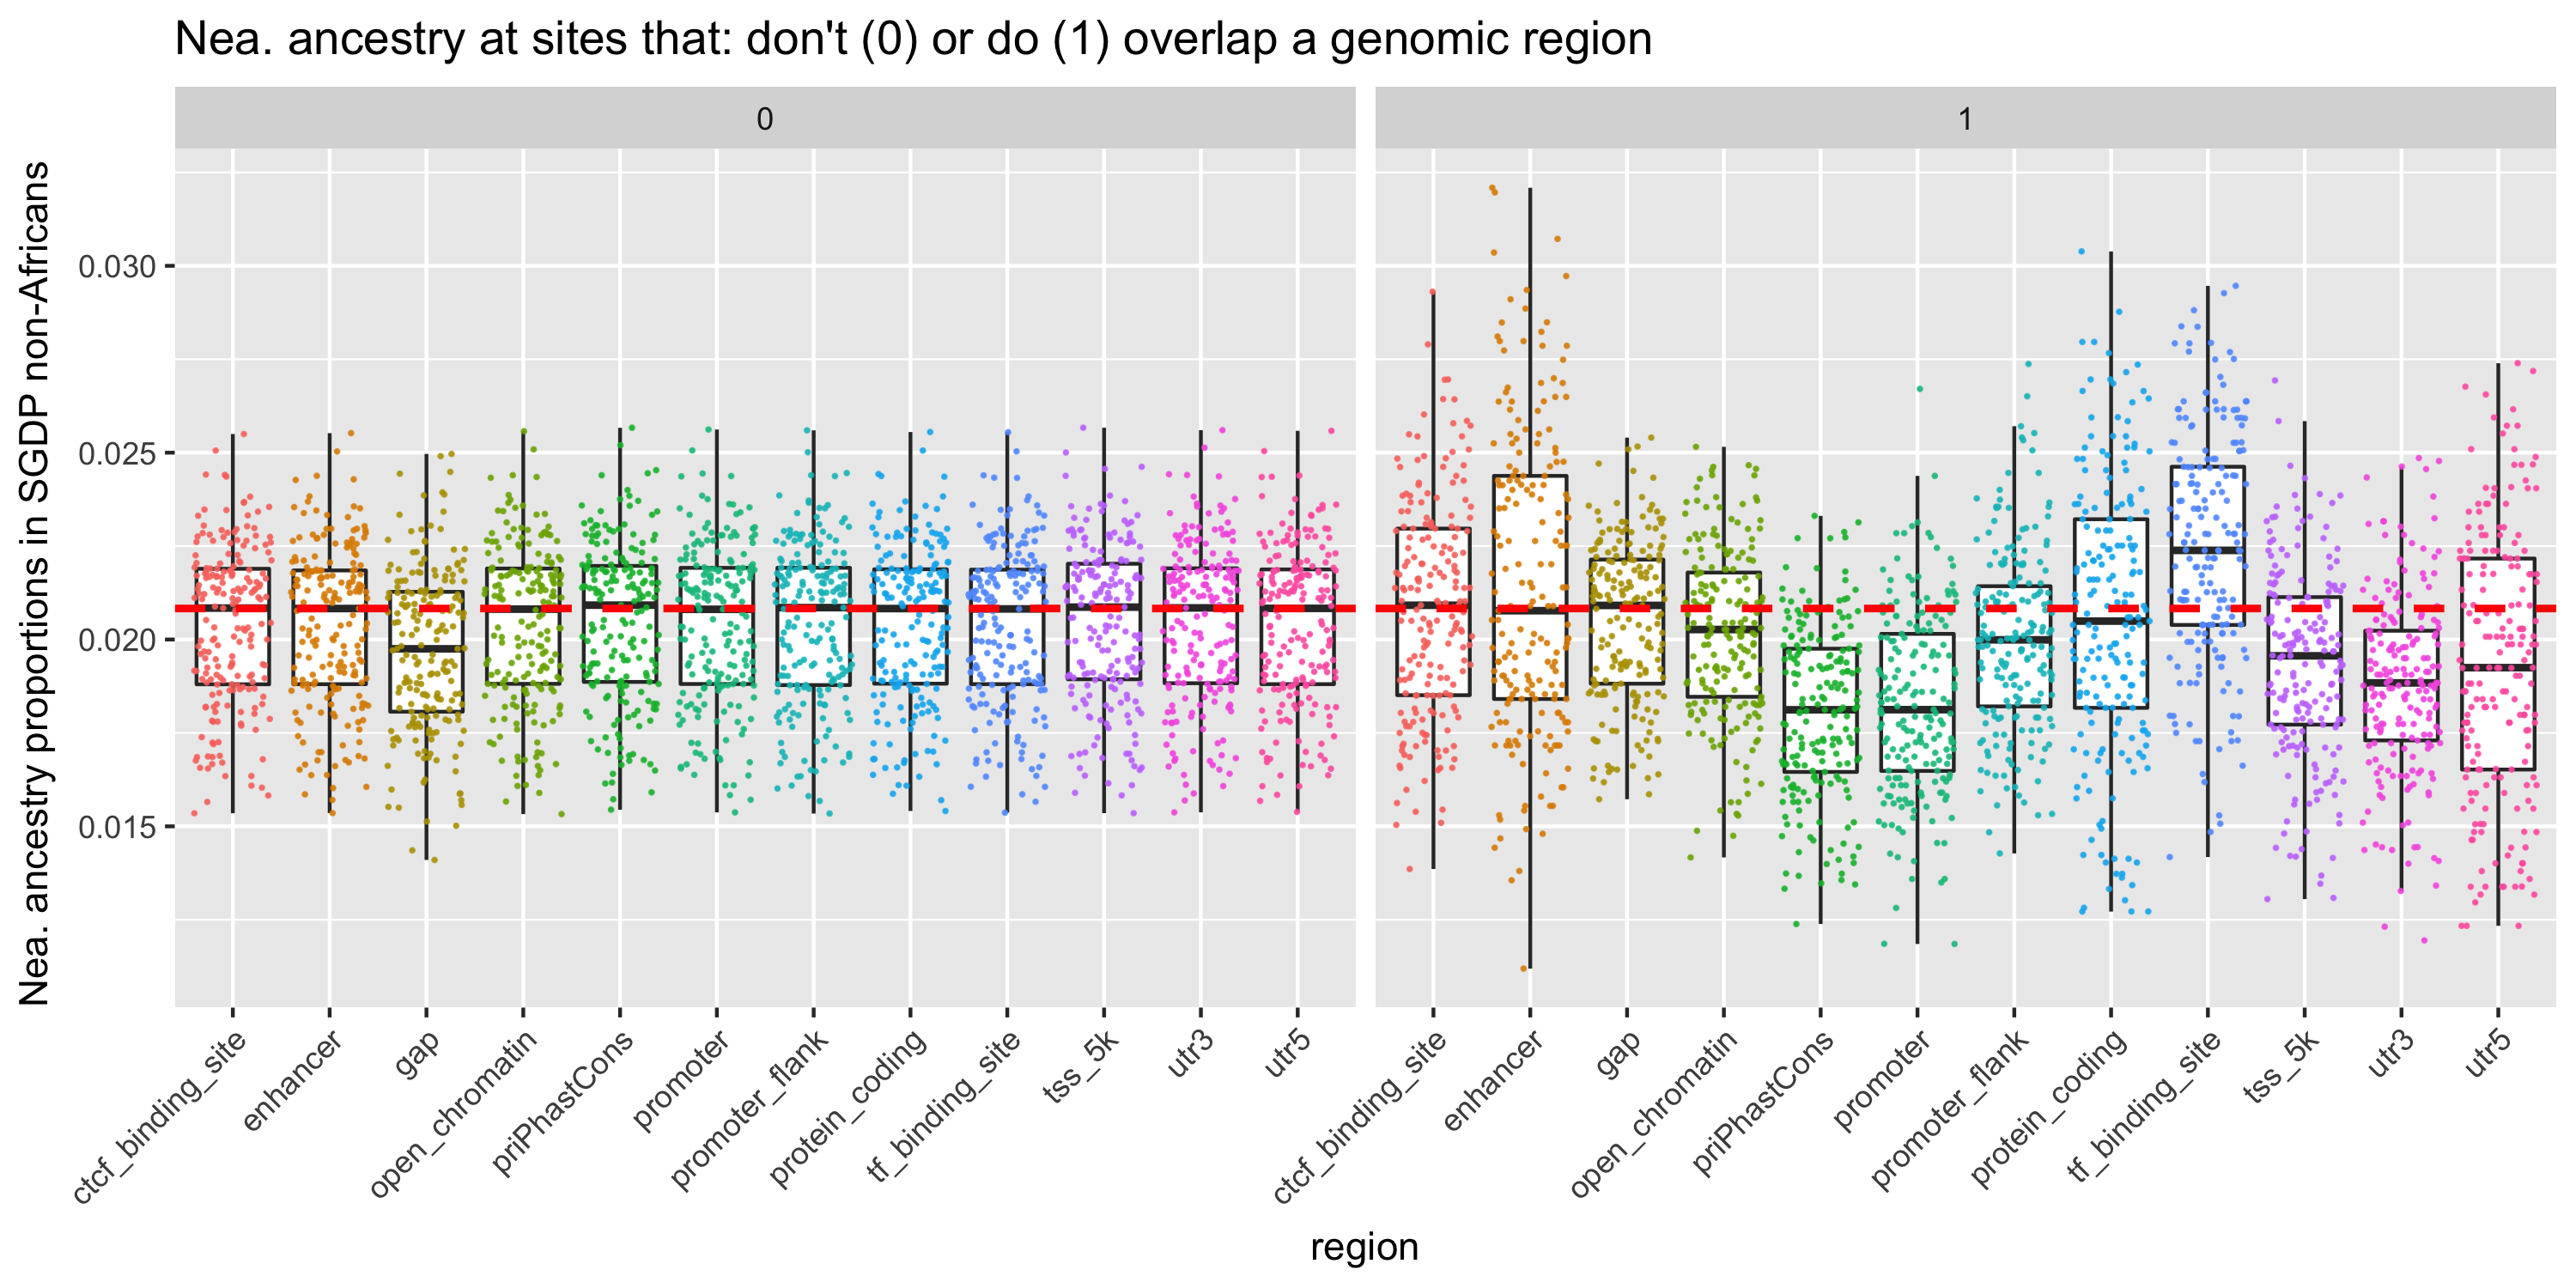

In [60]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

nea_regions %>%
ggplot(aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

## Neanderthal ancestry proportions at sites in different _unique_ functional regions

In [61]:
sample_ids <- filter(samples, pop != "EMH")$name

unique_sites <- (as.data.frame(sites) %>% select(starts_with("hits"), -hits_tss_5k, -hits_priPhastCons) %>% rowSums) %>% {. == 1 & !is.na(.) }

combined_unique <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>% filter(unique_sites)

nea_regions_uniq <- lapply(names(regions), function(r) {
    col <- paste0("hits_", r)
    hits <- select(tbl, chrom, start, col) %>% filter(unique_sites)

    filter(combined_unique, complete.cases(hits)) %>%
        select(col, one_of(sample_ids)) %>%
        gather(region, hits, -c(S_Chane_1:S_Yemenite_Jew_2)) %>%
        gather(name, gt, -region, -hits) %>%
        group_by(name, region, hits) %>%
        summarise(nea=mean(gt, na.rm=TRUE) / 2) %>%
        ungroup %>%
        mutate(hits=factor(hits),
               region=str_replace(region, "hits_", ""))
}) %>% bind_rows

Joining, by = c("seqnames", "start", "end")


In [62]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4998048,267.0,9968622,532.4,9968622,532.4
Vcells,253274909,1932.4,793046048,6050.5,1200939767,9162.5


In [63]:
genome_nea_uniq <- inner_join(
    select(as.data.frame(sites), seqnames, start, end, contains("hits_")),
    select(as.data.frame(genotypes), seqnames, start, end, one_of(sample_ids))
) %>%
    filter(unique_sites) %>% 
    summarise_at(sample_ids, function(i) { mean(i, na.rm=TRUE) / 2 }) %>%
    t %>% .[, 1]

Joining, by = c("seqnames", "start", "end")


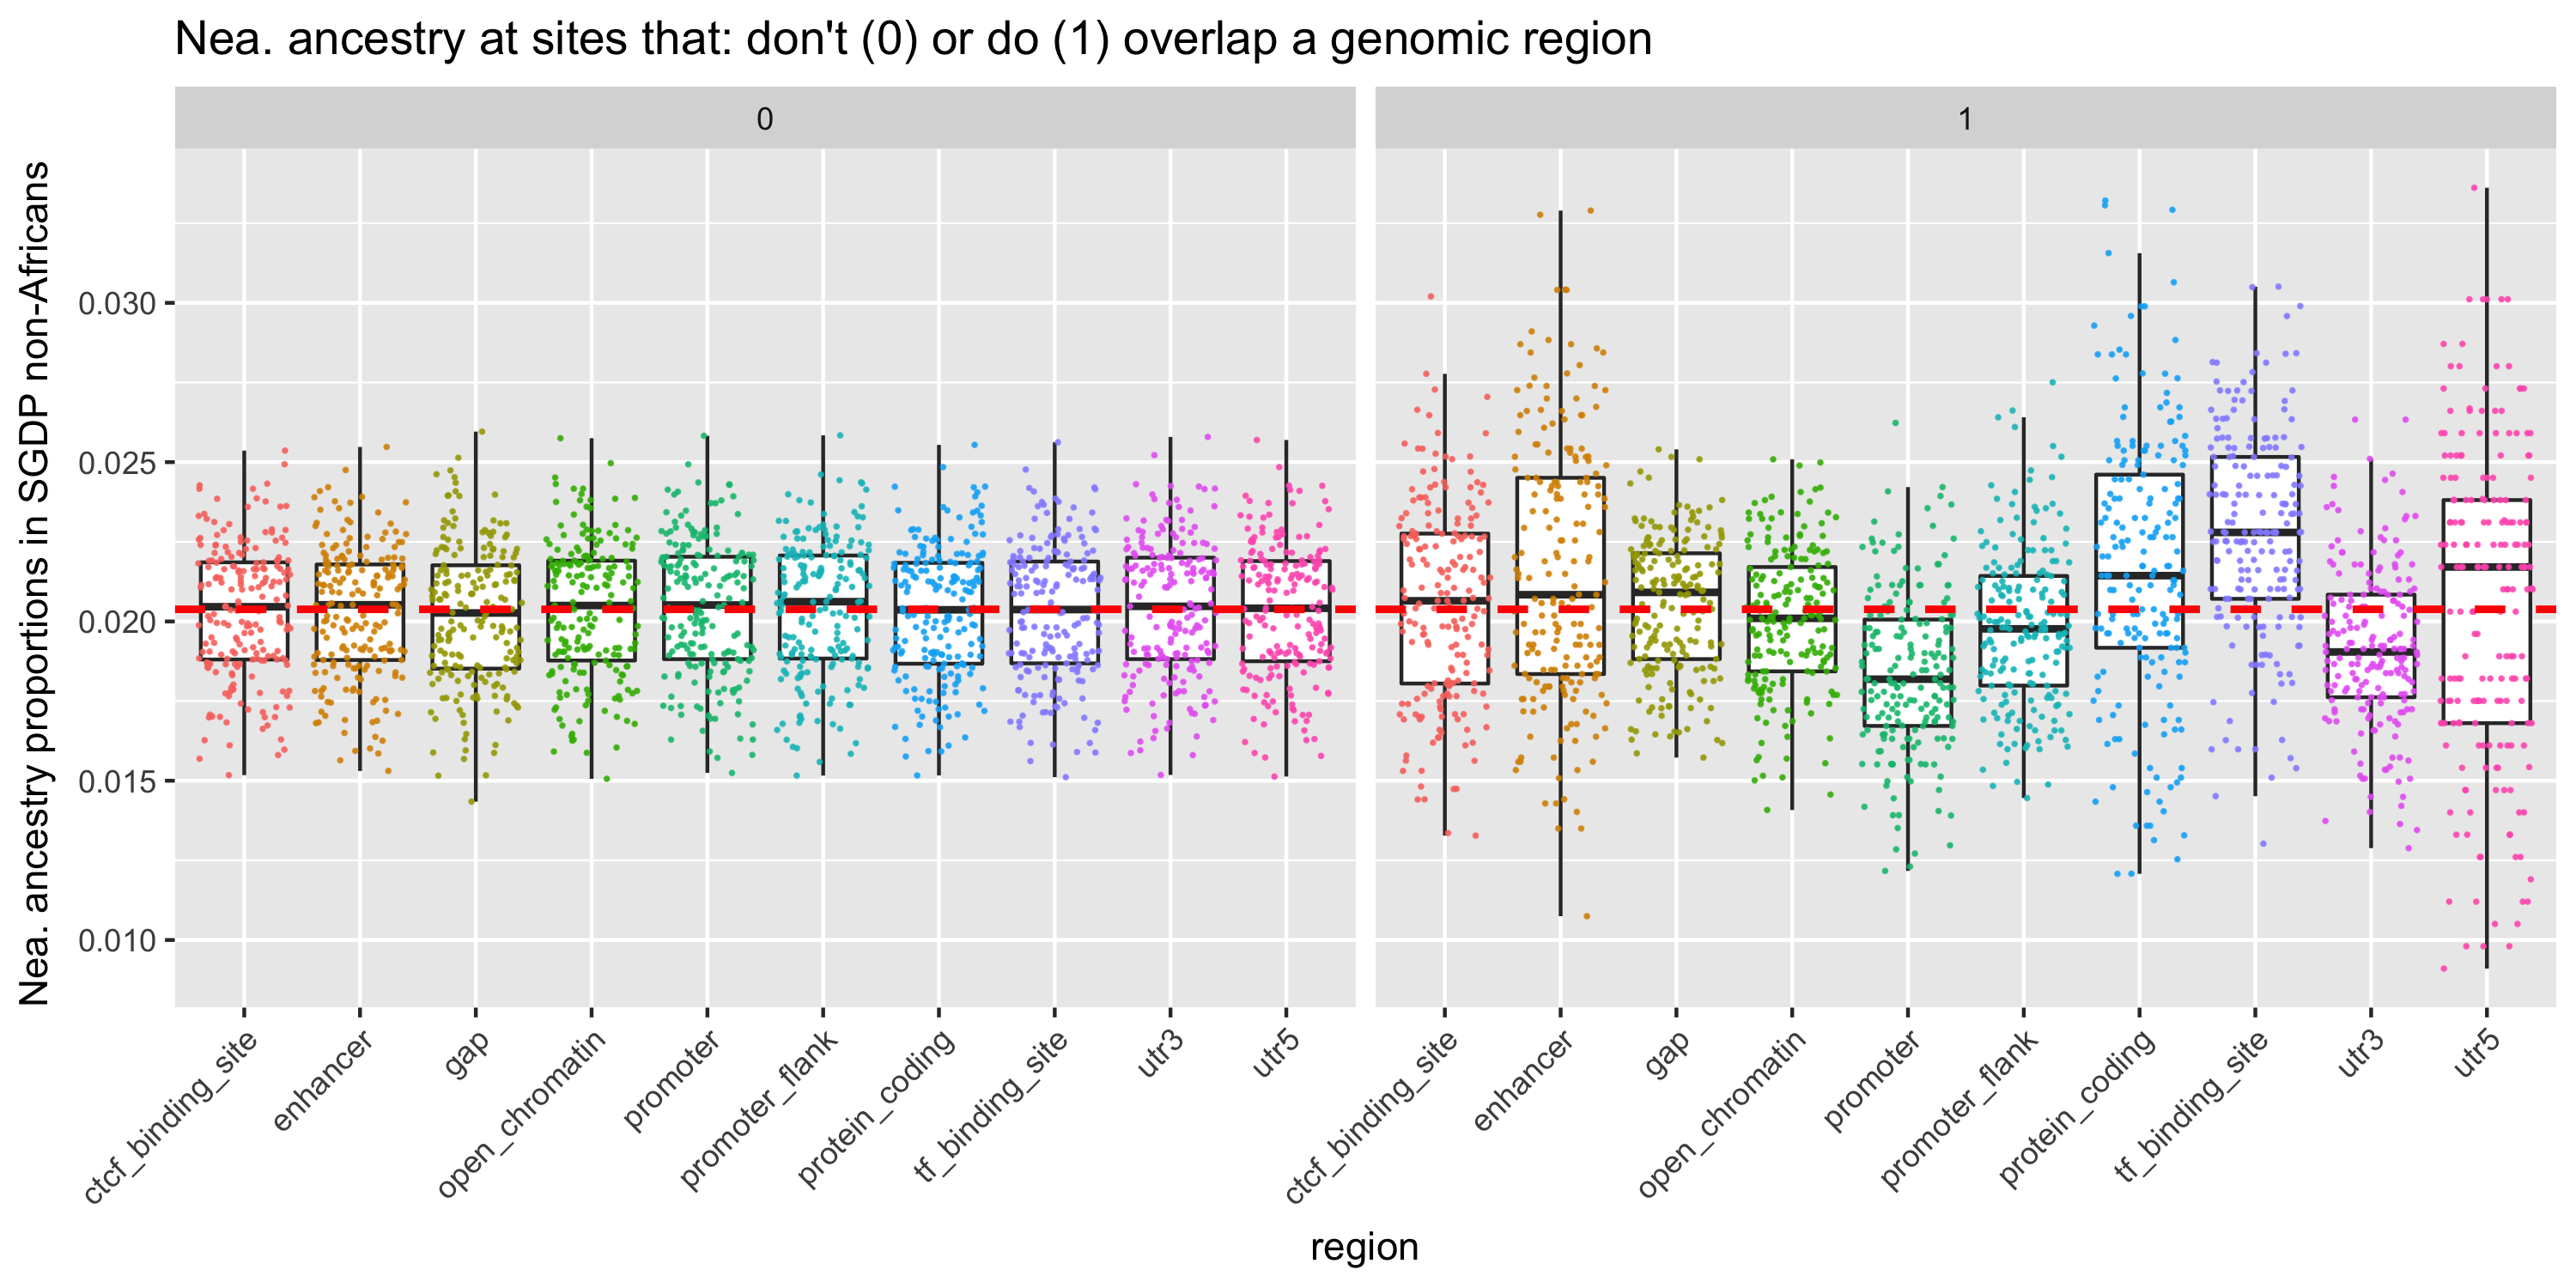

In [64]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res=300)

filter(nea_regions_uniq, !region %in% c("priPhastCons", "tss_5k")) %>%
ggplot(aes(region, nea)) +
    geom_boxplot(outlier.size=NA) +
    geom_jitter(aes(color=region), size=0.2, alpha=0.8) +
    geom_hline(yintercept=median(genome_nea_uniq), linetype=2, color="red", size=1) +
    facet_grid(. ~ hits) +
    theme(axis.text.x=element_text(angle=45, hjust=1), legend.position="none") +
    ggtitle("Nea. ancestry at sites that: don't (0) or do (1) overlap a genomic region") +
    labs(y="Nea. ancestry proportions in SGDP non-Africans ", "genomic region")

In [65]:
summary(fit <- glm(data=filter(as.data.frame(sites), unique_sites),
                   freq_all > 0 ~ hits_protein_coding + hits_utr5 + hits_utr3 + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + hits_enhancer + hits_open_chromatin + hits_tf_binding_site, family="binomial"))


Call:
glm(formula = freq_all > 0 ~ hits_protein_coding + hits_utr5 + 
    hits_utr3 + hits_promoter + hits_promoter_flank + hits_ctcf_binding_site + 
    hits_enhancer + hits_open_chromatin + hits_tf_binding_site, 
    family = "binomial", data = filter(as.data.frame(sites), 
        unique_sites))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.238  -1.195   1.118   1.160   1.252  

Coefficients:
                        Estimate Std. Error z value       Pr(>|z|)    
(Intercept)             0.040608   0.008946   4.539 0.000005651029 ***
hits_protein_coding    -0.086510   0.035894  -2.410       0.015947 *  
hits_utr5              -0.085433   0.075400  -1.133       0.257182    
hits_utr3              -0.106566   0.028961  -3.680       0.000234 ***
hits_promoter          -0.213813   0.034028  -6.284 0.000000000331 ***
hits_promoter_flank    -0.089075   0.020501  -4.345 0.000013933368 ***
hits_ctcf_binding_site  0.001814   0.026979   0.067       0.946401    
hits_enhance

<br><br><br><br><br><br><br><br><br><br>
## Formally testing the distribution differences

Statistical test to find out whether selection performed differently among different functional categories:

http://rpubs.com/ibecav/308410

### Non-parametric testing - Kruskal-Wallis rank sum test

In [66]:
library(dunn.test)

filter(nea_regions, hits == 1) %>% 
{ dunn.test(.[["nea"]], .[["region"]], method = "holm", alpha = 0.01) }

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 341.4626, df = 11, p-value = 0


                           Comparison of x by group                            
                                    (Holm)                                     
Col Mean-|
Row Mean |   ctcf_bin   enhancer        gap   open_chr   priPhast   promoter
---------+------------------------------------------------------------------
enhancer |  -0.328703
         |     0.7424
         |
     gap |   0.532561   0.861265
         |     0.8915     1.0000
         |
open_chr |   1.674001   2.002705   1.141440
         |     0.6118     0.3843     1.0000
         |
priPhast |   9.027859   9.356563   8.495298   7.353858
         |    0.0000*    0.0000*    0.0000*    0.0000*
         |
promoter |   8.393627   8.722331   7.861066   6.719626  -0.634231
         |    0.0000*    0.0000*    0.0000*    0.0000*     1.0000
         |
promoter |   2.654577   2.983281   2.122016   0.980575  -6.373282  -

<br><br><br><br><br>

## Size of overlaps between all pairs of genomic regions

In [67]:
functional_regions <- setdiff(names(regions), "gap")

In [68]:
overlaps <- matrix(rep(NA, length(functional_regions) ^ 2), nrow=length(functional_regions))
colnames(overlaps) <- rownames(overlaps) <- functional_regions

In [69]:
for (r1 in functional_regions) {
    for (r2 in setdiff(functional_regions, r1)) {
        r1_gr <- regions[[r1]]
        r2_gr <- regions[[r2]]

        overlaps[r1, r2] <- sum(width(IRanges::intersect(r1_gr, r2_gr))) / sum(width(r1_gr)) 
    }
}

In [70]:
overlaps

,protein_coding,utr5,utr3,tss_5k,ctcf_binding_site,enhancer,open_chromatin,promoter,promoter_flank,tf_binding_site,priPhastCons
protein_coding,NA,0.049916021,0.17361906,0.15142917,0.02761974,0.00289352438,0.0242140282,0.051009628,0.04172216865,0.0113411820,0.61536838
utr5,0.163437583,NA,0.03876457,0.50055027,0.02933340,0.00486345713,0.0185697922,0.401536277,0.08569840606,0.0146414516,0.24409811
utr3,0.156824280,0.010693970,NA,0.10055220,0.02465764,0.00654872449,0.0254803155,0.009075050,0.03306342978,0.0087620752,0.25579652
tss_5k,0.032546608,0.032857303,0.02392610,NA,0.03550089,0.00821501784,0.0190093200,0.080413857,0.04842326698,0.0083184854,0.05863172
ctcf_binding_site,0.022672166,0.007354004,0.02240831,0.13558651,NA,0.01488923312,0.0712938466,0.005935422,0.09195243562,0.0498221721,0.05382236
enhancer,0.005358768,0.002750876,0.01342699,0.07078646,0.03359207,NA,0.0000000000,0.000000000,0.00007655305,0.0000000000,0.08015083
open_chromatin,0.016004941,0.003748712,0.01864558,0.05845982,0.05740711,0.00000000000,NA,0.000000000,0.00039039729,0.0000000000,0.09872298
promoter,0.076098228,0.182951174,0.01498841,0.55815793,0.01078700,0.00000000000,0.0000000000,NA,0.00000000000,0.0000000000,0.15302011
promoter_flank,0.023632395,0.014825237,0.02073351,0.12761413,0.06344987,0.00002341346,0.0003345497,0.000000000,NA,0.0003891253,0.08112098
tf_binding_site,0.036599735,0.014430846,0.03130478,0.12490151,0.19587043,0.00000000000,0.0000000000,0.000000000,0.00221701286,NA,0.08811890


<br><br><br><br><br><br><br><br><br><br>
## Export coordinates of genomic regions and their sites in BED format

In [71]:
df_to_bed <- function(df, path) {
    df %>%
        mutate(start=as.integer(start - 1), end=as.integer(end)) %>%
        write_tsv(path, col_names=FALSE)
}

In [72]:
dir.create("../data/bed/")

Warning message in dir.create("../data/bed/"):
“'../data/bed' already exists”

#### Regions (for later simulation of Genomic Elements in SLiM)

In [73]:
for (r in names(regions)) {
    regions[[r]] %>%
        as.data.frame %>%
        select("seqnames", "start", "end") %>%
        filter(end - start > 0) %>% # remove 1bp "regions"
        df_to_bed(file.path("../data/bed/", paste0(r, "_regions.bed")))
}

#### Sites (for later simulation of informative positions in SLiM)

In [74]:
for (r in names(regions)) {
    filter(tbl, tbl[paste0("hits_", r)] == 1) %>%
        select(chrom, start, end) %>%
        df_to_bed(file.path("../data/bed/", paste0(r, "_sites.bed")))
}

<br><br><br><br><br><br><br><br><br><br>

In [75]:
save.image("../data/RData/introgression_predictors.RData")